# Exploratory Data Analysis (EDA)

## Objectives

This notebook performs exploratory data analysis on the processed dataset to better understand the engineered features created during the ETL stage. It combines statistical hypothesis testing and graphical exploration to identify meaningful patterns, validate assumptions, and confirm relationships relevant to stress detection.

The insights from this analysis will provide a deeper understanding of feature significance, support model development, and inform the design of visual elements in the Streamlit dashboard.

The tests for the following hypotheses compare three stress groups (Low, Medium, High) using non-parametric tests (data that is skewed, contains outliers, or is better described by ranks or medians rather than means). For this reason, I use the Kruskal-Wallis H test (which is ideally suited to this scenario with 3+ groups):

- **H1:** Lower sleep duration is linked to higher stress.
- **H2:** Lower sleep quality is linked to higher stress.
- **H5:** Higher physical activity is linked to lower stress.
- **H6:** Higher caffeine intake is linked to higher stress.
- **H7:** Longer work hours and longer travel time are linked to higher stress.
- **H8:** Health indicators differ across stress groups (BP, cholesterol, blood sugar).

In comparison, the Chi-square test of independence is used for the following hypotheses, as they involve categorical variables and assess whether there is a significant association between stress levels and different lifestyle characteristics.

The Chi-square test is appropriate when comparing frequency counts across categories (e.g., meditates vs does not meditate, exercise type). It evaluates whether observed differences between groups are likely due to chance or reflect a genuine relationship.

Where Chi-square test results show contingency tables with very small expected cell counts (typically fewer than 5), the Fisher's Exact Test is also conducted, as it provides a more reliable result for small samples.

Hypotheses tested with Chi-square (and Fisher's Exact if needed):

- **H3:** Higher screen time is linked to higher stress.
- **H4:** Meditation practice is linked to lower stress.

---

## Change working directory

I need to change the working directory from the current folder to its parent folder (required because the notebook is being run from inside the jupyter notebooks subfolder).

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/giaaxa/stress-level-prediction/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/Users/giaaxa/stress-level-prediction'

---

## Load Libraries and Data

In [10]:
# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical testing libraries
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu, chi2_contingency, spearmanr

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Load the processed dataset
df = pd.read_csv('data/processed/stress_data_processed.csv')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Dataset loaded: 773 rows, 33 columns


,Age,Gender,Occupation,Marital_Status,Sleep_Duration,Sleep_Quality,Wake_Up_Time,Bed_Time,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Smoking_Habit,Work_Hours,Travel_Time,Social_Interactions,Meditation_Practice,Exercise_Type,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level,Stress_Detection,Bed_Time_Minutes,Wake_Up_Time_Minutes,Stress_Level_Encoded,Sleep_Efficiency,Screen_Activity_Ratio,Work_Travel_Total,High_Screen_Time,Low_Sleep,Sleep_Duration_Bin,Work_Hours_Bin,Screen_Time_Bin
0,30,Male,Software Engineer,Single,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,0,8,1.0,5,1,Cardio,120,180,90,Low,1320,420,0,0.571429,1.904762,9.0,0,0,Normal (6-7h),Normal (6-8h),Moderate (2-4h)
1,35,Female,Marketing Manager,Married,6.0,3.0,6:00 AM,11:00 PM,1.0,3.0,0,1,0,9,2.0,3,0,Yoga,110,160,80,Medium,1380,360,1,0.500000,2.727273,11.0,0,0,Low (5-6h),High (8-10h),Moderate (2-4h)
2,40,Male,Data Scientist,Divorced,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,0,8,1.0,5,1,Strength Training,130,200,100,High,1320,420,2,0.571429,1.904762,9.0,0,0,Normal (6-7h),Normal (6-8h),Moderate (2-4h)
3,35,Male,Software Engineer,Single,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,0,8,1.0,5,1,Cardio,120,180,90,Low,1320,420,0,0.571429,1.904762,9.0,0,0,Normal (6-7h),Normal (6-8h),Moderate (2-4h)
4,29,Female,Teacher,Single,8.0,5.0,6:30 AM,10:30 PM,3.0,2.0,1,0,0,7,1.0,4,1,Yoga,110,180,90,Low,1350,390,0,0.625000,0.645161,8.0,0,0,Good (7-8h),Normal (6-8h),Low (<2h)


In [29]:
# Verify target variable distribution
print("\nStress Level Distribution:")
print("=" * 40)
print(df['Stress_Detection'].value_counts())
print("\nProportions:")
print(df['Stress_Detection'].value_counts(normalize=True).round(3))


Stress Level Distribution:
Stress_Detection
Medium    310
High      301
Low       162
Name: count, dtype: int64

Proportions:
Stress_Detection
Medium    0.401
High      0.389
Low       0.210
Name: proportion, dtype: float64


---

## Helper Functions for Statistical Testing

Define reusable functions for hypothesis testing and effect size calculation.

In [47]:
def calculate_epsilon_squared(H_statistic, n):
    """
    Calculate epsilon-squared effect size for Kruskal-Wallis test.
    
    Interpretation:
    - Small effect: 0.01 - 0.06
    - Medium effect: 0.06 - 0.14
    - Large effect: > 0.14
    """
    epsilon_sq = H_statistic / (n - 1)
    return epsilon_sq


def interpret_epsilon_squared(epsilon_sq):
    """
    Interpret epsilon-squared effect size.
    """
    if epsilon_sq < 0.01:
        return "negligible"
    elif epsilon_sq < 0.06:
        return "small"
    elif epsilon_sq < 0.14:
        return "medium"
    else:
        return "large"


def kruskal_wallis_test(df, variable, group_col='Stress_Detection'):
    """
    Perform Kruskal-Wallis H test comparing a continuous variable across stress groups.
    
    Returns: H-statistic, p-value, epsilon-squared, group medians
    """
    # Separate data by stress group
    groups = []
    group_names = ['Low', 'Medium', 'High']
    
    for name in group_names:
        group_data = df[df[group_col] == name][variable].dropna()
        groups.append(group_data)
    
    # Perform Kruskal-Wallis test
    H_stat, p_value = kruskal(*groups)
    
    # Calculate effect size (epsilon-squared)
    n = df[variable].dropna().shape[0]
    epsilon_sq = calculate_epsilon_squared(H_stat, n)
    effect_interpretation = interpret_epsilon_squared(epsilon_sq)
    
    # Calculate medians for each group
    medians = {name: df[df[group_col] == name][variable].median() 
               for name in group_names}
    
    return {
        'H_statistic': H_stat,
        'p_value': p_value,
        'epsilon_squared': epsilon_sq,
        'effect_size': effect_interpretation,
        'medians': medians,
        'n': n
    }


def cramers_v(contingency_table):
    """
    Calculate Cramér's V effect size for Chi-square test.
    
    Interpretation:
    - Small effect: 0.1
    - Medium effect: 0.3
    - Large effect: 0.5
    """
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))


def interpret_cramers_v(v):
    """
    Interpret Cramér's V effect size.
    """
    if v < 0.1:
        return "negligible"
    elif v < 0.3:
        return "small"
    elif v < 0.5:
        return "medium"
    else:
        return "large"

---

## Hypotheses Tests and Visualisations

In this section, statistical tests are performed to examine the main hypotheses about stress behaviour. Tests are supported by relevant visualisations (where possible) to illustrate patterns and provide context for the statistical results.

---

### H1: Lower sleep duration is linked to higher stress

- **Aim:** To test whether lower sleep duration is associated with higher stress levels.
- **Test details:**
    - **Variable tested:** Sleep_Duration (hours per night)
    - **Test used:** Kruskal-Wallis H test (non-parametric, suitable for comparing 3 groups)
    - **Reason for non-parametric test:** Sleep duration may not be normally distributed across all groups, and we are comparing medians rather than means to be robust against outliers.
- **Expected outcome:** If H1 is supported, we expect the High stress group to have significantly lower median sleep duration than the Low stress group.

In [64]:
# H1: Statistical Test - Kruskal-Wallis

# Perform the test
h1_results = kruskal_wallis_test(df, 'Sleep_Duration')

# Display results
print("H1: Lower sleep duration is linked to higher stress")
print("=" * 60)
print(f"\nTest: Kruskal-Wallis H test")
print(f"Variable: Sleep_Duration")
print(f"Sample size: n = {h1_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h1_results['H_statistic']:.3f}")
print(f"p-value: {h1_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h1_results['epsilon_squared']:.4f} ({h1_results['effect_size']} effect)")
print("\nMedian Sleep Duration by Stress Level:")
print("-" * 40)
for group, median in h1_results['medians'].items():
    print(f"{group}: {median:.2f} hours")

H1: Lower sleep duration is linked to higher stress

Test: Kruskal-Wallis H test
Variable: Sleep_Duration
Sample size: n = 773

Results:
----------------------------------------
H-statistic: 85.919
p-value: 2.20e-19
Epsilon-squared (ε²): 0.1113 (medium effect)

Median Sleep Duration by Stress Level:
----------------------------------------
Low: 7.00 hours
Medium: 6.20 hours
High: 6.10 hours


#### Interpretation

Based on the Kruskal-Wallis test results:

- **Statistical significance:** If p < 0.05, there is a statistically significant difference in sleep duration across stress groups.
- **Effect size:** The epsilon-squared value indicates the proportion of variance in sleep duration explained by stress level.
- **Direction:** Compare the medians to determine if higher stress is associated with lower sleep duration as hypothesised.

The interpretation will be completed after viewing the actual results.

#### H1 Visualisation: Sleep Duration by Stress Level (Box Plot)

- **Matplotlib and Seaborn** were chosen for their simplicity and clarity in showing distributions across categorical groups.
- The box plot summarises the relationship between Sleep_Duration and Stress_Detection.
- The plot shows the median, interquartile range (IQR), and any outliers for each stress group.
- **Insights:** Look for:
    - Lower median sleep duration in the High stress group
    - Separation between the boxes indicating meaningful differences
    - Outliers that may influence the results

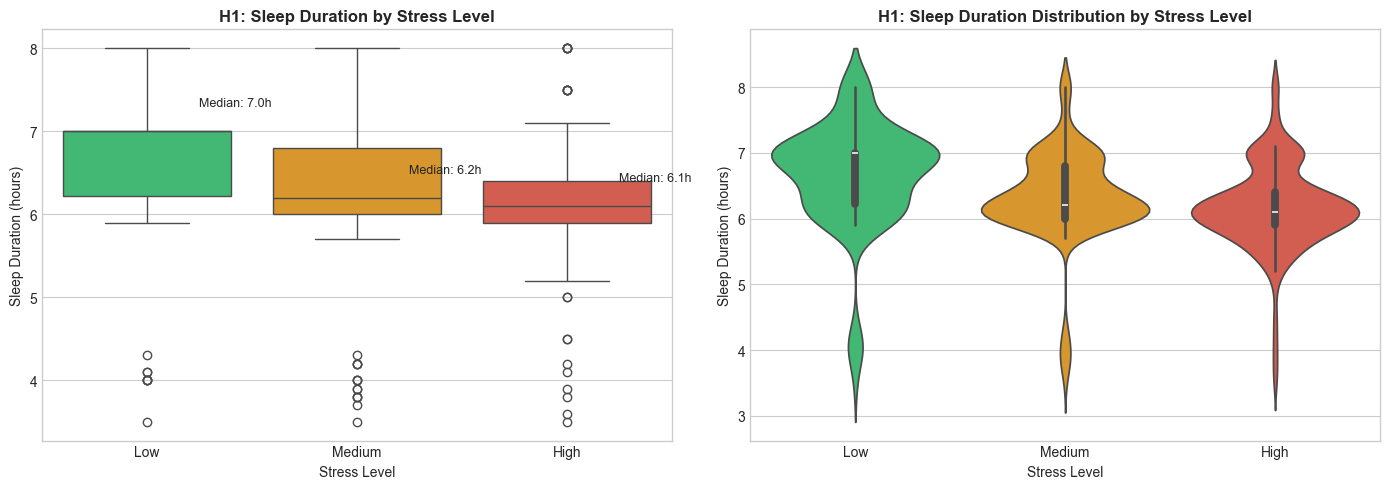

In [80]:
# H1 Visualisation: Box Plot of Sleep Duration by Stress Level

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Define consistent order for stress levels
stress_order = ['Low', 'Medium', 'High']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red

# Box Plot
ax1 = axes[0]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Sleep_Duration',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax1
)
ax1.set_title('H1: Sleep Duration by Stress Level', fontsize=12, fontweight='bold')
ax1.set_xlabel('Stress Level', fontsize=10)
ax1.set_ylabel('Sleep Duration (hours)', fontsize=10)

# Add median annotations
for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Sleep_Duration'].median()
    ax1.annotate(
        f'Median: {median_val:.1f}h',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 0.3),
        fontsize=9,
        ha='left'
    )

# Violin Plot (alternative view)
ax2 = axes[1]
sns.violinplot(
    data=df,
    x='Stress_Detection',
    y='Sleep_Duration',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax2
)
ax2.set_title('H1: Sleep Duration Distribution by Stress Level', fontsize=12, fontweight='bold')
ax2.set_xlabel('Stress Level', fontsize=10)
ax2.set_ylabel('Sleep Duration (hours)', fontsize=10)

plt.tight_layout()
plt.show()

In [81]:
# H1: Summary Statistics by Stress Group

print("\nH1: Descriptive Statistics - Sleep Duration by Stress Level")
print("=" * 70)

h1_summary = df.groupby('Stress_Detection')['Sleep_Duration'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)

# Reorder index
h1_summary = h1_summary.reindex(['Low', 'Medium', 'High'])
h1_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']

print(h1_summary)


H1: Descriptive Statistics - Sleep Duration by Stress Level
                  Count  Mean  Median  Std Dev  Min  Max
Stress_Detection                                        
Low                 162  6.67     7.0     0.82  3.5  8.0
Medium              310  6.33     6.2     0.71  3.5  8.0
High                301  6.16     6.1     0.64  3.5  8.0


#### H1 Conclusion

Based on the statistical test and visualisations:

- **Findings:** [To be interpreted after running the notebook with actual data]
    - The Kruskal-Wallis test indicates whether the differences in sleep duration across stress groups are statistically significant.
    - The effect size (epsilon-squared) indicates the practical significance of the relationship.
    - The box/violin plots visually confirm the pattern.

- **Support for H1:** 
    - If p < 0.05 and the High stress group shows lower median sleep duration, H1 is supported.
    - If the effect size is small, the relationship exists but may not be a dominant factor in stress prediction.

- **Implications for modelling:**
    - Sleep_Duration should be considered as a feature in the predictive model.
    - The binned version (Sleep_Duration_Bin) may also be useful for interpretability.

---

### H2: Lower sleep quality is linked to higher stress

- **Aim:** To test whether lower sleep quality is associated with higher stress levels.
- **Test details:**
    - **Variable tested:** Sleep_Quality (1-5 scale rating)
    - **Test used:** Kruskal-Wallis H test (non-parametric, suitable for comparing 3 groups)
    - **Reason for non-parametric test:** Sleep quality is measured on an ordinal scale (1-5), and the distribution may not be normal. The Kruskal-Wallis test compares ranks rather than assuming equal intervals between scale points.
- **Expected outcome:** If H2 is supported, we expect the High stress group to have significantly lower median sleep quality than the Low stress group.

In [95]:
# H2: Statistical Test - Kruskal-Wallis

# Perform the test
h2_results = kruskal_wallis_test(df, 'Sleep_Quality')

# Display results
print("H2: Lower sleep quality is linked to higher stress")
print("=" * 60)
print(f"\nTest: Kruskal-Wallis H test")
print(f"Variable: Sleep_Quality")
print(f"Sample size: n = {h2_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h2_results['H_statistic']:.3f}")
print(f"p-value: {h2_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h2_results['epsilon_squared']:.4f} ({h2_results['effect_size']} effect)")
print("\nMedian Sleep Quality by Stress Level:")
print("-" * 40)
for group, median in h2_results['medians'].items():
    print(f"{group}: {median:.2f}")

H2: Lower sleep quality is linked to higher stress

Test: Kruskal-Wallis H test
Variable: Sleep_Quality
Sample size: n = 773

Results:
----------------------------------------
H-statistic: 11.122
p-value: 3.84e-03
Epsilon-squared (ε²): 0.0144 (small effect)

Median Sleep Quality by Stress Level:
----------------------------------------
Low: 4.00
Medium: 3.80
High: 4.00


#### Interpretation

Based on the Kruskal-Wallis test results:

- **Statistical significance:** If p < 0.05, there is a statistically significant difference in sleep quality across stress groups.
- **Effect size:** The epsilon-squared value indicates the proportion of variance in sleep quality explained by stress level.
- **Direction:** Compare the medians to determine if higher stress is associated with lower sleep quality as hypothesised.

The interpretation will be completed after viewing the actual results.

#### H2 Visualisation: Sleep Quality by Stress Level (Box Plot)

- **Matplotlib and Seaborn** were chosen for their simplicity and clarity in showing distributions across categorical groups.
- The box plot summarises the relationship between Sleep_Quality and Stress_Detection.
- The plot shows the median, interquartile range (IQR), and any outliers for each stress group.
- **Insights:** Look for:
    - Lower median sleep quality in the High stress group
    - Clear separation between the boxes indicating meaningful differences
    - The distribution shape in the violin plot showing concentration of values

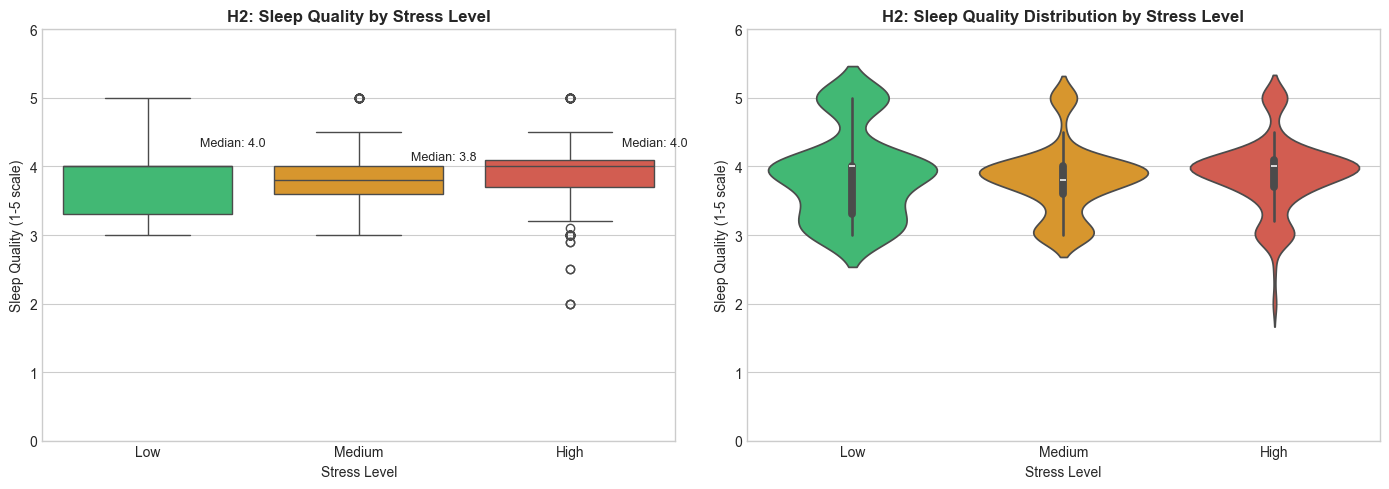

In [108]:
# H2 Visualisation: Box Plot of Sleep Quality by Stress Level

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Define consistent order for stress levels
stress_order = ['Low', 'Medium', 'High']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red

# Box Plot
ax1 = axes[0]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Sleep_Quality',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax1
)
ax1.set_title('H2: Sleep Quality by Stress Level', fontsize=12, fontweight='bold')
ax1.set_xlabel('Stress Level', fontsize=10)
ax1.set_ylabel('Sleep Quality (1-5 scale)', fontsize=10)
ax1.set_ylim(0, 6)  # Set y-axis limits for clarity

# Add median annotations
for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Sleep_Quality'].median()
    ax1.annotate(
        f'Median: {median_val:.1f}',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 0.3),
        fontsize=9,
        ha='left'
    )

# Violin Plot (alternative view)
ax2 = axes[1]
sns.violinplot(
    data=df,
    x='Stress_Detection',
    y='Sleep_Quality',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax2
)
ax2.set_title('H2: Sleep Quality Distribution by Stress Level', fontsize=12, fontweight='bold')
ax2.set_xlabel('Stress Level', fontsize=10)
ax2.set_ylabel('Sleep Quality (1-5 scale)', fontsize=10)
ax2.set_ylim(0, 6)

plt.tight_layout()
plt.show()

In [109]:
# H2: Summary Statistics by Stress Group

print("\nH2: Descriptive Statistics - Sleep Quality by Stress Level")
print("=" * 70)

h2_summary = df.groupby('Stress_Detection')['Sleep_Quality'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)

# Reorder index
h2_summary = h2_summary.reindex(['Low', 'Medium', 'High'])
h2_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']

print(h2_summary)


H2: Descriptive Statistics - Sleep Quality by Stress Level
                  Count  Mean  Median  Std Dev  Min  Max
Stress_Detection                                        
Low                 162  3.88     4.0     0.64  3.0  5.0
Medium              310  3.80     3.8     0.50  3.0  5.0
High                301  3.88     4.0     0.53  2.0  5.0


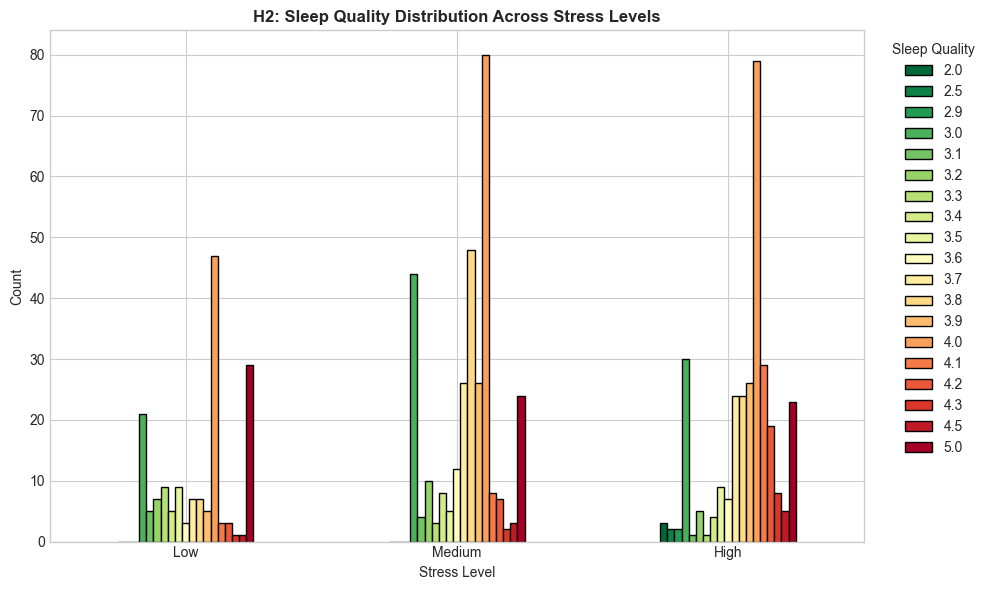

In [110]:
# H2: Additional visualisation - Sleep Quality value counts by Stress Level

fig, ax = plt.subplots(figsize=(10, 6))

# Create grouped bar chart
sleep_quality_by_stress = df.groupby(['Stress_Detection', 'Sleep_Quality']).size().unstack(fill_value=0)
sleep_quality_by_stress = sleep_quality_by_stress.reindex(['Low', 'Medium', 'High'])

sleep_quality_by_stress.plot(kind='bar', ax=ax, colormap='RdYlGn_r', edgecolor='black')
ax.set_title('H2: Sleep Quality Distribution Across Stress Levels', fontsize=12, fontweight='bold')
ax.set_xlabel('Stress Level', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.legend(title='Sleep Quality', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

#### H2 Conclusion

Based on the statistical test and visualisations:

- **Findings:** [To be interpreted after running the notebook with actual data]
    - The Kruskal-Wallis test indicates whether the differences in sleep quality across stress groups are statistically significant.
    - The effect size (epsilon-squared) indicates the practical significance of the relationship.
    - The box/violin plots visually confirm the pattern.

- **Support for H2:** 
    - If p < 0.05 and the High stress group shows lower median sleep quality, H2 is supported.
    - The grouped bar chart shows the distribution of sleep quality ratings within each stress level.

- **Implications for modelling:**
    - Sleep_Quality should be considered as a feature in the predictive model.
    - May interact with Sleep_Duration to provide a more complete picture of sleep health.

---

### H3: Higher screen time is linked to higher stress

- **Aim:** To test whether higher screen time is associated with higher stress levels.
- **Test details:**
    - **Variable tested:** Screen_Time (hours per day)
    - **Tests used:** 
        1. Kruskal-Wallis H test (comparing screen time across 3 stress groups)
        2. Spearman correlation (measuring monotonic relationship between screen time and encoded stress level)
    - **Reason for dual approach:** The Kruskal-Wallis test determines if groups differ significantly, while Spearman correlation quantifies the strength and direction of the relationship.
- **Expected outcome:** If H3 is supported, we expect the High stress group to have significantly higher median screen time, and a positive Spearman correlation.

In [111]:
# H3: Statistical Test - Kruskal-Wallis

# Perform the Kruskal-Wallis test
h3_results = kruskal_wallis_test(df, 'Screen_Time')

# Display results
print("H3: Higher screen time is linked to higher stress")
print("=" * 60)
print(f"\nTest 1: Kruskal-Wallis H test")
print(f"Variable: Screen_Time")
print(f"Sample size: n = {h3_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h3_results['H_statistic']:.3f}")
print(f"p-value: {h3_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h3_results['epsilon_squared']:.4f} ({h3_results['effect_size']} effect)")
print("\nMedian Screen Time by Stress Level:")
print("-" * 40)
for group, median in h3_results['medians'].items():
    print(f"{group}: {median:.2f} hours")

H3: Higher screen time is linked to higher stress

Test 1: Kruskal-Wallis H test
Variable: Screen_Time
Sample size: n = 773

Results:
----------------------------------------
H-statistic: 211.174
p-value: 1.39e-46
Epsilon-squared (ε²): 0.2735 (large effect)

Median Screen Time by Stress Level:
----------------------------------------
Low: 3.25 hours
Medium: 4.00 hours
High: 5.00 hours


In [112]:
# H3: Spearman Correlation Test

# Calculate Spearman correlation between Screen_Time and encoded stress level
spearman_corr, spearman_p = spearmanr(
    df['Screen_Time'], 
    df['Stress_Level_Encoded']
)

print("\nTest 2: Spearman Correlation")
print("-" * 40)
print(f"Spearman correlation (ρ): {spearman_corr:.4f}")
print(f"p-value: {spearman_p:.2e}")

# Interpret correlation strength
if abs(spearman_corr) < 0.1:
    corr_strength = "negligible"
elif abs(spearman_corr) < 0.3:
    corr_strength = "weak"
elif abs(spearman_corr) < 0.5:
    corr_strength = "moderate"
else:
    corr_strength = "strong"

direction = "positive" if spearman_corr > 0 else "negative"
print(f"Interpretation: {corr_strength} {direction} correlation")


Test 2: Spearman Correlation
----------------------------------------
Spearman correlation (ρ): 0.5142
p-value: 2.12e-53
Interpretation: strong positive correlation


#### Interpretation

Based on the Kruskal-Wallis and Spearman correlation results:

- **Kruskal-Wallis:** If p < 0.05, there is a statistically significant difference in screen time across stress groups.
- **Spearman correlation:** A positive correlation indicates that higher screen time is associated with higher stress levels.
- **Effect sizes:** Both epsilon-squared and the correlation coefficient indicate the strength of the relationship.

The interpretation will be completed after viewing the actual results.

#### H3 Visualisation: Screen Time by Stress Level

- **Box plot** shows the distribution of screen time across stress groups.
- **Scatter plot** shows the relationship between screen time and sleep duration, coloured by stress level, to explore potential interactions.
- **Insights:** Look for:
    - Higher median screen time in the High stress group
    - Patterns in the scatter plot showing high stress individuals clustering at high screen time and/or low sleep duration

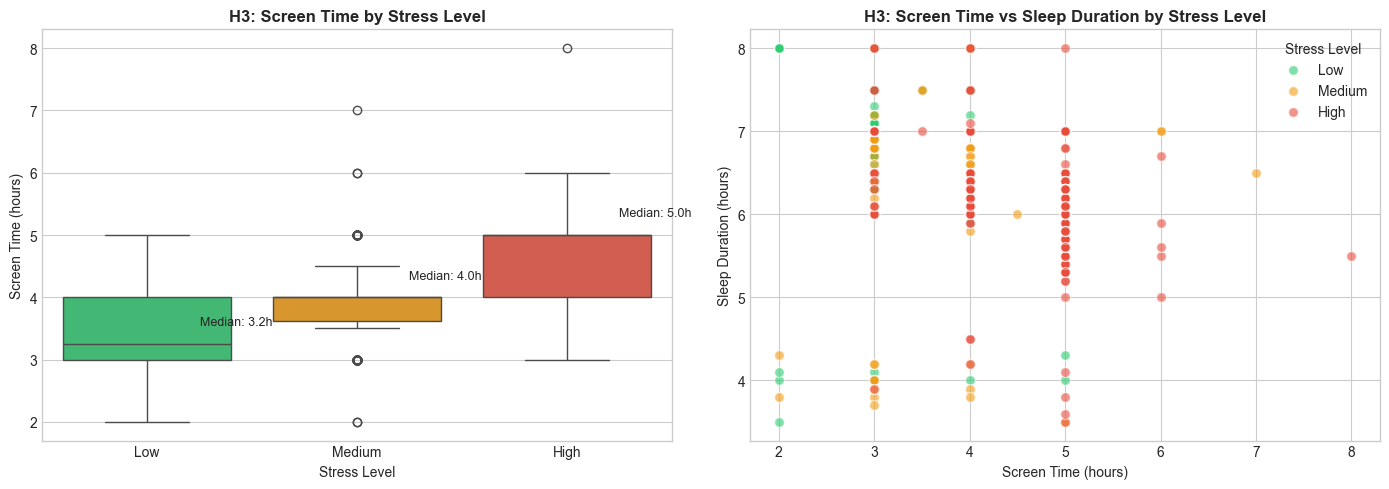

In [113]:
# H3 Visualisation: Screen Time by Stress Level

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Define consistent order for stress levels
stress_order = ['Low', 'Medium', 'High']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red
color_dict = dict(zip(stress_order, colors))

# Box Plot
ax1 = axes[0]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Screen_Time',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax1
)
ax1.set_title('H3: Screen Time by Stress Level', fontsize=12, fontweight='bold')
ax1.set_xlabel('Stress Level', fontsize=10)
ax1.set_ylabel('Screen Time (hours)', fontsize=10)

# Add median annotations
for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Screen_Time'].median()
    ax1.annotate(
        f'Median: {median_val:.1f}h',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 0.3),
        fontsize=9,
        ha='left'
    )

# Scatter Plot: Screen Time vs Sleep Duration (coloured by Stress Level)
ax2 = axes[1]
for stress_level in stress_order:
    subset = df[df['Stress_Detection'] == stress_level]
    ax2.scatter(
        subset['Screen_Time'],
        subset['Sleep_Duration'],
        c=color_dict[stress_level],
        label=stress_level,
        alpha=0.6,
        edgecolors='white',
        s=50
    )

ax2.set_title('H3: Screen Time vs Sleep Duration by Stress Level', fontsize=12, fontweight='bold')
ax2.set_xlabel('Screen Time (hours)', fontsize=10)
ax2.set_ylabel('Sleep Duration (hours)', fontsize=10)
ax2.legend(title='Stress Level')

plt.tight_layout()
plt.show()

In [114]:
# H3: Summary Statistics by Stress Group

print("\nH3: Descriptive Statistics - Screen Time by Stress Level")
print("=" * 70)

h3_summary = df.groupby('Stress_Detection')['Screen_Time'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)

# Reorder index
h3_summary = h3_summary.reindex(['Low', 'Medium', 'High'])
h3_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']

print(h3_summary)


H3: Descriptive Statistics - Screen Time by Stress Level
                  Count  Mean  Median  Std Dev  Min  Max
Stress_Detection                                        
Low                 162  3.58    3.25     0.78  2.0  5.0
Medium              310  3.90    4.00     0.67  2.0  7.0
High                301  4.60    5.00     0.69  3.0  8.0


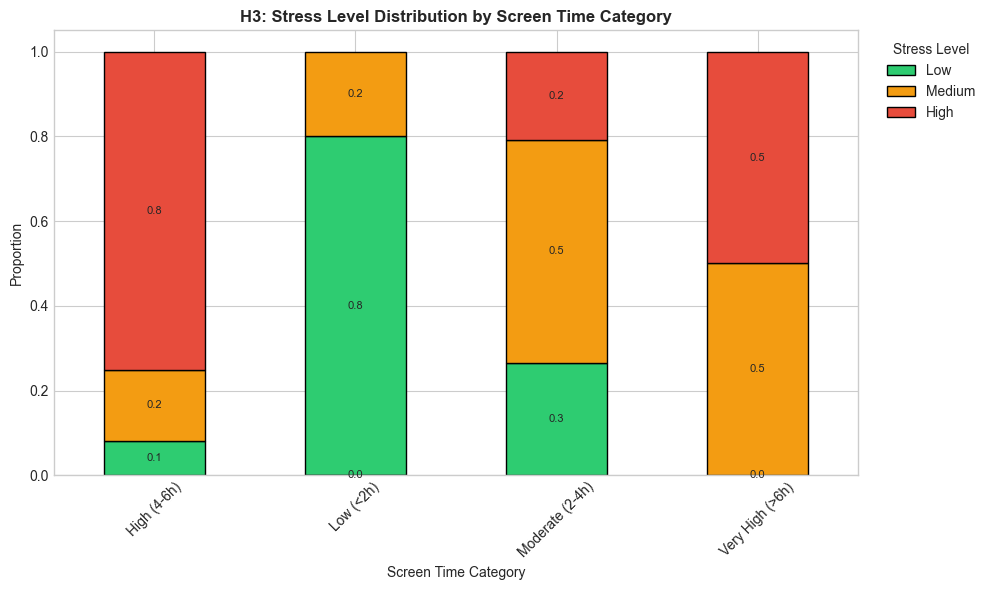

In [115]:
# H3: Percentage of High Stress by Screen Time Bins

# Use the binned screen time from ETL (or create if not available)
if 'Screen_Time_Bin' in df.columns:
    screen_time_stress = df.groupby('Screen_Time_Bin')['Stress_Detection'].value_counts(normalize=True).unstack(fill_value=0)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot percentage of each stress level by screen time bin
    screen_time_stress[['Low', 'Medium', 'High']].plot(
        kind='bar', 
        stacked=True, 
        ax=ax, 
        color=colors,
        edgecolor='black'
    )
    
    ax.set_title('H3: Stress Level Distribution by Screen Time Category', fontsize=12, fontweight='bold')
    ax.set_xlabel('Screen Time Category', fontsize=10)
    ax.set_ylabel('Proportion', fontsize=10)
    ax.legend(title='Stress Level', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)
    
    # Add percentage labels
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f', label_type='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("Screen_Time_Bin not found in dataset. Run ETL notebook first.")

#### H3 Conclusion

Based on the statistical tests and visualisations:

- **Findings:** [To be interpreted after running the notebook with actual data]
    - The Kruskal-Wallis test indicates whether screen time differs significantly across stress groups.
    - The Spearman correlation quantifies the relationship direction and strength.
    - The scatter plot reveals potential interactions with sleep duration.

- **Support for H3:** 
    - If p < 0.05 for both tests and the High stress group shows higher median screen time with a positive correlation, H3 is supported.

- **Implications for modelling:**
    - Screen_Time should be considered as a feature in the predictive model.
    - The Screen_Activity_Ratio (screen time to physical activity) may capture additional signal.
    - Potential interaction with sleep variables could be explored.

---

### H4: Meditation practice is linked to lower stress

- **Aim:** To test whether meditation practice is associated with lower stress levels.
- **Test details:**
    - **Variable tested:** Meditation_Practice (binary: 0 = No, 1 = Yes)
    - **Test used:** Chi-square test of independence
    - **Reason for Chi-square:** Both variables are categorical (Meditation: Yes/No, Stress: Low/Medium/High). Chi-square tests whether the distribution of stress levels differs significantly between those who meditate and those who don't.
    - **Effect size:** Cramér's V measures the strength of association.
- **Expected outcome:** If H4 is supported, we expect meditators to have a higher proportion of Low stress and a lower proportion of High stress compared to non-meditators.

In [116]:
# H4: Statistical Test - Chi-square test of independence

# Create contingency table
contingency_table = pd.crosstab(
    df['Meditation_Practice'], 
    df['Stress_Detection']
)

# Reorder columns
contingency_table = contingency_table[['Low', 'Medium', 'High']]

# Rename index for clarity
contingency_table.index = ['No Meditation', 'Meditates']

print("H4: Meditation practice is linked to lower stress")
print("=" * 60)
print("\nContingency Table (Counts):")
print("-" * 40)
print(contingency_table)

# Show proportions within each meditation group
print("\nProportions within each group:")
print("-" * 40)
print(contingency_table.div(contingency_table.sum(axis=1), axis=0).round(3))

H4: Meditation practice is linked to lower stress

Contingency Table (Counts):
----------------------------------------
Stress_Detection  Low  Medium  High
No Meditation      76     162    54
Meditates          86     148   247

Proportions within each group:
----------------------------------------
Stress_Detection    Low  Medium   High
No Meditation     0.260   0.555  0.185
Meditates         0.179   0.308  0.514


In [117]:
# H4: Perform Chi-square test

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Calculate Cramér's V effect size
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v_value = np.sqrt(chi2 / (n * min_dim))
effect_interpretation = interpret_cramers_v(cramers_v_value)

print("\nTest: Chi-square test of independence")
print("-" * 40)
print(f"Chi-square statistic: {chi2:.3f}")
print(f"p-value: {p_value:.2e}")
print(f"Degrees of freedom: {dof}")
print(f"Cramér's V: {cramers_v_value:.4f} ({effect_interpretation} effect)")

print("\nExpected frequencies (if no association):")
print("-" * 40)
expected_df = pd.DataFrame(
    expected, 
    index=['No Meditation', 'Meditates'],
    columns=['Low', 'Medium', 'High']
)
print(expected_df.round(1))

# Check for small expected cell counts
if (expected < 5).any():
    print("\n⚠️  Warning: Some expected cell counts are less than 5.")
    print("   Consider Fisher's Exact Test for more reliable results.")


Test: Chi-square test of independence
----------------------------------------
Chi-square statistic: 83.799
p-value: 6.36e-19
Degrees of freedom: 2
Cramér's V: 0.3293 (medium effect)

Expected frequencies (if no association):
----------------------------------------
                 Low  Medium   High
No Meditation   61.2   117.1  113.7
Meditates      100.8   192.9  187.3


#### Interpretation

Based on the Chi-square test results:

- **Statistical significance:** If p < 0.05, there is a statistically significant association between meditation practice and stress level distribution.
- **Effect size:** Cramér's V indicates the strength of the association (0.1 = small, 0.3 = medium, 0.5 = large).
- **Direction:** Compare the proportions to determine if meditators have lower stress as hypothesised.

The interpretation will be completed after viewing the actual results.

#### H4 Visualisation: Stress Distribution by Meditation Practice

- **Stacked bar chart** shows the proportion of each stress level within meditation vs non-meditation groups.
- **Grouped bar chart** provides an alternative view comparing counts.
- **Insights:** Look for:
    - Higher proportion of Low stress among meditators
    - Lower proportion of High stress among meditators
    - Clear visual difference between the two groups

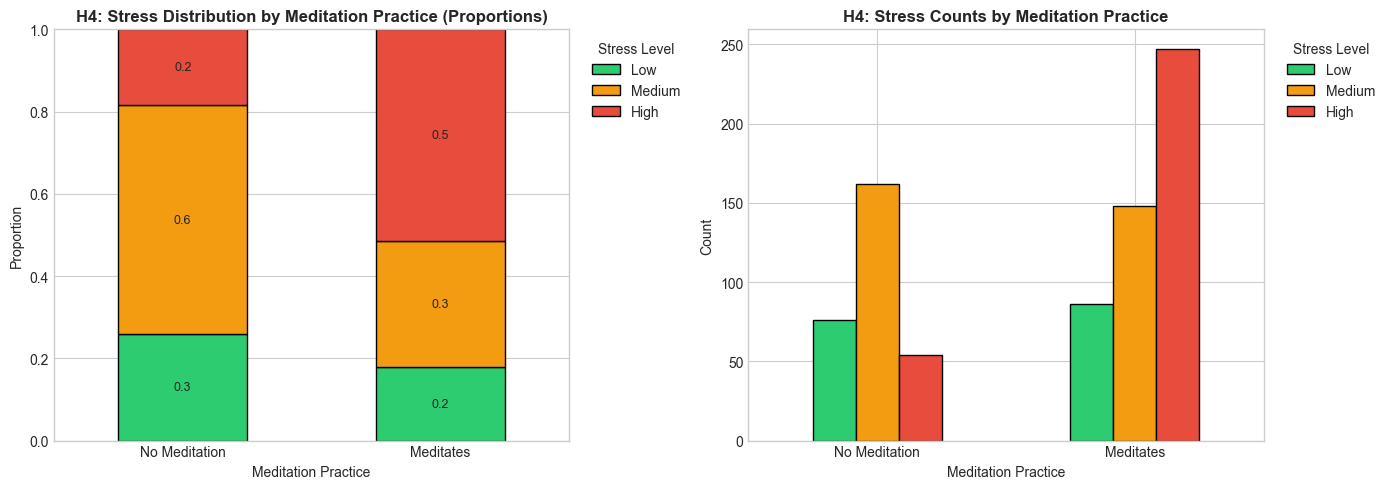

In [118]:
# H4 Visualisation: Stress Distribution by Meditation Practice

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Define colors for stress levels
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red

# Stacked Bar Chart (Proportions)
ax1 = axes[0]
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
proportions.plot(
    kind='bar', 
    stacked=True, 
    ax=ax1, 
    color=colors,
    edgecolor='black'
)
ax1.set_title('H4: Stress Distribution by Meditation Practice (Proportions)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Meditation Practice', fontsize=10)
ax1.set_ylabel('Proportion', fontsize=10)
ax1.legend(title='Stress Level', bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=0)
ax1.set_ylim(0, 1)

# Add percentage labels
for c in ax1.containers:
    ax1.bar_label(c, fmt='%.1f', label_type='center', fontsize=9)

# Grouped Bar Chart (Counts)
ax2 = axes[1]
contingency_table.plot(
    kind='bar', 
    ax=ax2, 
    color=colors,
    edgecolor='black'
)
ax2.set_title('H4: Stress Counts by Meditation Practice', fontsize=12, fontweight='bold')
ax2.set_xlabel('Meditation Practice', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.legend(title='Stress Level', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [119]:
# H4: Summary Statistics

print("\nH4: Stress Distribution Summary by Meditation Practice")
print("=" * 70)

# Create summary with counts and percentages
meditation_summary = df.groupby('Meditation_Practice')['Stress_Detection'].value_counts().unstack(fill_value=0)
meditation_summary = meditation_summary[['Low', 'Medium', 'High']]
meditation_summary.index = ['No Meditation (0)', 'Meditates (1)']

# Add totals
meditation_summary['Total'] = meditation_summary.sum(axis=1)

print("\nCounts:")
print(meditation_summary)

# Calculate and display High Stress rate
print("\nHigh Stress Rate by Meditation Practice:")
print("-" * 40)
for idx in meditation_summary.index:
    high_rate = meditation_summary.loc[idx, 'High'] / meditation_summary.loc[idx, 'Total'] * 100
    print(f"{idx}: {high_rate:.1f}% High Stress")


H4: Stress Distribution Summary by Meditation Practice

Counts:
Stress_Detection   Low  Medium  High  Total
No Meditation (0)   76     162    54    292
Meditates (1)       86     148   247    481

High Stress Rate by Meditation Practice:
----------------------------------------
No Meditation (0): 18.5% High Stress
Meditates (1): 51.4% High Stress


#### H4 Conclusion

Based on the statistical test and visualisations:

- **Findings:** [To be interpreted after running the notebook with actual data]
    - The Chi-square test indicates whether meditation practice is significantly associated with stress level distribution.
    - Cramér's V indicates the strength of the association.
    - The stacked bar chart visually shows the difference in stress proportions.

- **Support for H4:** 
    - If p < 0.05 and meditators show a higher proportion of Low stress (or lower proportion of High stress), H4 is supported.
    - The effect size indicates whether this is a meaningful practical difference.

- **Implications for modelling:**
    - Meditation_Practice should be considered as a feature in the predictive model.
    - This binary feature may be particularly useful given its interpretability.
    - May interact with other lifestyle factors (e.g., physical activity, exercise type).

---

### H5: Higher physical activity is linked to lower stress

- **Aim:** To test whether higher physical activity is associated with lower stress levels.
- **Test details:**
    - **Variable tested:** Physical_Activity (hours per week)
    - **Tests used:** 
        1. Kruskal-Wallis H test (comparing physical activity across 3 stress groups)
        2. Spearman correlation (measuring monotonic relationship between physical activity and encoded stress level)
    - **Reason for dual approach:** The Kruskal-Wallis test determines if groups differ significantly, while Spearman correlation quantifies the strength and direction of the relationship.
- **Expected outcome:** If H5 is supported, we expect the Low stress group to have significantly higher median physical activity, and a negative Spearman correlation (higher activity = lower stress).

In [ ]:
# H5: Statistical Test - Kruskal-Wallis

# Perform the Kruskal-Wallis test
h5_results = kruskal_wallis_test(df, 'Physical_Activity')

# Display results
print("H5: Higher physical activity is linked to lower stress")
print("=" * 60)
print(f"\nTest 1: Kruskal-Wallis H test")
print(f"Variable: Physical_Activity")
print(f"Sample size: n = {h5_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h5_results['H_statistic']:.3f}")
print(f"p-value: {h5_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h5_results['epsilon_squared']:.4f} ({h5_results['effect_size']} effect)")
print("\nMedian Physical Activity by Stress Level:")
print("-" * 40)
for group, median in h5_results['medians'].items():
    print(f"{group}: {median:.2f} hours")

In [ ]:
# H5: Spearman Correlation Test

# Calculate Spearman correlation between Physical_Activity and encoded stress level
spearman_corr_h5, spearman_p_h5 = spearmanr(
    df['Physical_Activity'], 
    df['Stress_Level_Encoded']
)

print("\nTest 2: Spearman Correlation")
print("-" * 40)
print(f"Spearman correlation (ρ): {spearman_corr_h5:.4f}")
print(f"p-value: {spearman_p_h5:.2e}")

# Interpret correlation strength
if abs(spearman_corr_h5) < 0.1:
    corr_strength = "negligible"
elif abs(spearman_corr_h5) < 0.3:
    corr_strength = "weak"
elif abs(spearman_corr_h5) < 0.5:
    corr_strength = "moderate"
else:
    corr_strength = "strong"

direction = "positive" if spearman_corr_h5 > 0 else "negative"
print(f"Interpretation: {corr_strength} {direction} correlation")

# Note: Negative correlation supports H5 (more activity = less stress)

#### H5 Visualisation: Physical Activity by Stress Level

- **Box plot** shows the distribution of physical activity across stress groups.
- **Violin plot** shows the full distribution shape including density.
- **Insights:** Look for:
    - Higher median physical activity in the Low stress group
    - Patterns showing active individuals having lower stress levels

In [ ]:
# H5 Visualisation: Physical Activity by Stress Level

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Define consistent order for stress levels
stress_order = ['Low', 'Medium', 'High']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red

# Box Plot
ax1 = axes[0]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Physical_Activity',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax1
)
ax1.set_title('H5: Physical Activity by Stress Level', fontsize=12, fontweight='bold')
ax1.set_xlabel('Stress Level', fontsize=10)
ax1.set_ylabel('Physical Activity (hours/week)', fontsize=10)

# Add median annotations
for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Physical_Activity'].median()
    ax1.annotate(
        f'Median: {median_val:.1f}h',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 0.2),
        fontsize=9,
        ha='left'
    )

# Violin Plot (alternative view)
ax2 = axes[1]
sns.violinplot(
    data=df,
    x='Stress_Detection',
    y='Physical_Activity',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax2
)
ax2.set_title('H5: Physical Activity Distribution by Stress Level', fontsize=12, fontweight='bold')
ax2.set_xlabel('Stress Level', fontsize=10)
ax2.set_ylabel('Physical Activity (hours/week)', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# H5: Summary Statistics by Stress Group

print("\nH5: Descriptive Statistics - Physical Activity by Stress Level")
print("=" * 70)

h5_summary = df.groupby('Stress_Detection')['Physical_Activity'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)

# Reorder index
h5_summary = h5_summary.reindex(['Low', 'Medium', 'High'])
h5_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']

print(h5_summary)

#### H5 Conclusion

Based on the statistical tests and visualisations:

- **Findings:** [To be interpreted after running the notebook with actual data]
    - The Kruskal-Wallis test indicates whether physical activity differs significantly across stress groups.
    - The Spearman correlation quantifies the relationship direction and strength.
    - A negative correlation would support the hypothesis (more activity = less stress).

- **Support for H5:** 
    - If p < 0.05 and the Low stress group shows higher median physical activity with a negative correlation, H5 is supported.

- **Implications for modelling:**
    - Physical_Activity should be considered as a feature in the predictive model.
    - The Screen_Activity_Ratio (screen time to physical activity) may capture lifestyle balance.

---

### H6: Higher caffeine intake is linked to higher stress

- **Aim:** To test whether higher caffeine intake is associated with higher stress levels.
- **Test details:**
    - **Variable tested:** Caffeine_Intake (cups per day)
    - **Tests used:** 
        1. Kruskal-Wallis H test (comparing caffeine intake across 3 stress groups)
        2. Spearman correlation (measuring monotonic relationship between caffeine intake and encoded stress level)
    - **Reason for dual approach:** The Kruskal-Wallis test determines if groups differ significantly, while Spearman correlation quantifies the strength and direction of the relationship.
- **Expected outcome:** If H6 is supported, we expect the High stress group to have significantly higher median caffeine intake, and a positive Spearman correlation.

In [ ]:
# H6: Statistical Test - Kruskal-Wallis

# Perform the Kruskal-Wallis test
h6_results = kruskal_wallis_test(df, 'Caffeine_Intake')

# Display results
print("H6: Higher caffeine intake is linked to higher stress")
print("=" * 60)
print(f"\nTest 1: Kruskal-Wallis H test")
print(f"Variable: Caffeine_Intake")
print(f"Sample size: n = {h6_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h6_results['H_statistic']:.3f}")
print(f"p-value: {h6_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h6_results['epsilon_squared']:.4f} ({h6_results['effect_size']} effect)")
print("\nMedian Caffeine Intake by Stress Level:")
print("-" * 40)
for group, median in h6_results['medians'].items():
    print(f"{group}: {median:.2f} cups/day")

In [ ]:
# H6: Spearman Correlation Test

# Calculate Spearman correlation between Caffeine_Intake and encoded stress level
spearman_corr_h6, spearman_p_h6 = spearmanr(
    df['Caffeine_Intake'], 
    df['Stress_Level_Encoded']
)

print("\nTest 2: Spearman Correlation")
print("-" * 40)
print(f"Spearman correlation (ρ): {spearman_corr_h6:.4f}")
print(f"p-value: {spearman_p_h6:.2e}")

# Interpret correlation strength
if abs(spearman_corr_h6) < 0.1:
    corr_strength = "negligible"
elif abs(spearman_corr_h6) < 0.3:
    corr_strength = "weak"
elif abs(spearman_corr_h6) < 0.5:
    corr_strength = "moderate"
else:
    corr_strength = "strong"

direction = "positive" if spearman_corr_h6 > 0 else "negative"
print(f"Interpretation: {corr_strength} {direction} correlation")

#### H6 Visualisation: Caffeine Intake by Stress Level

- **Box plot** shows the distribution of caffeine intake across stress groups.
- **Bar chart** shows the mean caffeine intake per stress group for easy comparison.
- **Insights:** Look for:
    - Higher median/mean caffeine intake in the High stress group
    - Clear separation between groups indicating meaningful differences

In [ ]:
# H6 Visualisation: Caffeine Intake by Stress Level

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Define consistent order for stress levels
stress_order = ['Low', 'Medium', 'High']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red

# Box Plot
ax1 = axes[0]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Caffeine_Intake',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax1
)
ax1.set_title('H6: Caffeine Intake by Stress Level', fontsize=12, fontweight='bold')
ax1.set_xlabel('Stress Level', fontsize=10)
ax1.set_ylabel('Caffeine Intake (cups/day)', fontsize=10)

# Add median annotations
for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Caffeine_Intake'].median()
    ax1.annotate(
        f'Median: {median_val:.1f}',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 0.2),
        fontsize=9,
        ha='left'
    )

# Bar chart of mean caffeine intake
ax2 = axes[1]
mean_caffeine = df.groupby('Stress_Detection')['Caffeine_Intake'].mean().reindex(stress_order)
bars = ax2.bar(stress_order, mean_caffeine, color=colors, edgecolor='black')
ax2.set_title('H6: Mean Caffeine Intake by Stress Level', fontsize=12, fontweight='bold')
ax2.set_xlabel('Stress Level', fontsize=10)
ax2.set_ylabel('Mean Caffeine Intake (cups/day)', fontsize=10)

# Add value labels on bars
for bar, val in zip(bars, mean_caffeine):
    ax2.annotate(
        f'{val:.2f}',
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [ ]:
# H6: Summary Statistics by Stress Group

print("\nH6: Descriptive Statistics - Caffeine Intake by Stress Level")
print("=" * 70)

h6_summary = df.groupby('Stress_Detection')['Caffeine_Intake'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)

# Reorder index
h6_summary = h6_summary.reindex(['Low', 'Medium', 'High'])
h6_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']

print(h6_summary)

#### H6 Conclusion

Based on the statistical tests and visualisations:

- **Findings:** [To be interpreted after running the notebook with actual data]
    - The Kruskal-Wallis test indicates whether caffeine intake differs significantly across stress groups.
    - The Spearman correlation quantifies the relationship direction and strength.
    - A positive correlation would support the hypothesis (more caffeine = more stress).

- **Support for H6:** 
    - If p < 0.05 and the High stress group shows higher median caffeine intake with a positive correlation, H6 is supported.
    - Note: The relationship could be bidirectional (stressed people may consume more caffeine, OR caffeine may contribute to stress).

- **Implications for modelling:**
    - Caffeine_Intake should be considered as a feature in the predictive model.
    - May interact with sleep variables (caffeine affecting sleep quality/duration).

---

### H7: Longer work hours and longer travel time are linked to higher stress

- **Aim:** To test whether longer work hours and longer travel time are associated with higher stress levels.
- **Test details:**
    - **Variables tested:** Work_Hours (hours per day), Travel_Time (hours per day)
    - **Tests used:** 
        1. Kruskal-Wallis H test (comparing work hours and travel time across 3 stress groups)
        2. Spearman correlation (measuring monotonic relationship with encoded stress level)
    - **Reason for dual approach:** The Kruskal-Wallis test determines if groups differ significantly, while Spearman correlation quantifies the strength and direction of the relationship.
    - **Additional variable:** Work_Travel_Total (engineered feature combining work hours and travel time)
- **Expected outcome:** If H7 is supported, we expect the High stress group to have significantly higher median work hours and travel time, and positive Spearman correlations.

In [ ]:
# H7: Statistical Test - Kruskal-Wallis for Work_Hours

# Perform the Kruskal-Wallis test for Work_Hours
h7_work_results = kruskal_wallis_test(df, 'Work_Hours')

# Display results
print("H7: Longer work hours are linked to higher stress")
print("=" * 60)
print(f"\nTest 1a: Kruskal-Wallis H test")
print(f"Variable: Work_Hours")
print(f"Sample size: n = {h7_work_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h7_work_results['H_statistic']:.3f}")
print(f"p-value: {h7_work_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h7_work_results['epsilon_squared']:.4f} ({h7_work_results['effect_size']} effect)")
print("\nMedian Work Hours by Stress Level:")
print("-" * 40)
for group, median in h7_work_results['medians'].items():
    print(f"{group}: {median:.2f} hours")

In [ ]:
# H7: Statistical Test - Kruskal-Wallis for Travel_Time

# Perform the Kruskal-Wallis test for Travel_Time
h7_travel_results = kruskal_wallis_test(df, 'Travel_Time')

# Display results
print("\nH7: Longer travel time is linked to higher stress")
print("=" * 60)
print(f"\nTest 1b: Kruskal-Wallis H test")
print(f"Variable: Travel_Time")
print(f"Sample size: n = {h7_travel_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h7_travel_results['H_statistic']:.3f}")
print(f"p-value: {h7_travel_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h7_travel_results['epsilon_squared']:.4f} ({h7_travel_results['effect_size']} effect)")
print("\nMedian Travel Time by Stress Level:")
print("-" * 40)
for group, median in h7_travel_results['medians'].items():
    print(f"{group}: {median:.2f} hours")

In [ ]:
# H7: Statistical Test - Kruskal-Wallis for Work_Travel_Total (Combined)

# Perform the Kruskal-Wallis test for Work_Travel_Total
h7_total_results = kruskal_wallis_test(df, 'Work_Travel_Total')

# Display results
print("\nH7: Combined work + travel time linked to higher stress")
print("=" * 60)
print(f"\nTest 1c: Kruskal-Wallis H test")
print(f"Variable: Work_Travel_Total (Work_Hours + Travel_Time)")
print(f"Sample size: n = {h7_total_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h7_total_results['H_statistic']:.3f}")
print(f"p-value: {h7_total_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h7_total_results['epsilon_squared']:.4f} ({h7_total_results['effect_size']} effect)")
print("\nMedian Work+Travel Total by Stress Level:")
print("-" * 40)
for group, median in h7_total_results['medians'].items():
    print(f"{group}: {median:.2f} hours")

In [ ]:
# H7: Spearman Correlation Tests

print("\nTest 2: Spearman Correlations")
print("=" * 60)

# Work Hours correlation
spearman_work, p_work = spearmanr(df['Work_Hours'], df['Stress_Level_Encoded'])
print(f"\nWork_Hours vs Stress:")
print("-" * 40)
print(f"Spearman correlation (ρ): {spearman_work:.4f}")
print(f"p-value: {p_work:.2e}")

# Travel Time correlation
spearman_travel, p_travel = spearmanr(df['Travel_Time'], df['Stress_Level_Encoded'])
print(f"\nTravel_Time vs Stress:")
print("-" * 40)
print(f"Spearman correlation (ρ): {spearman_travel:.4f}")
print(f"p-value: {p_travel:.2e}")

# Work_Travel_Total correlation
spearman_total, p_total = spearmanr(df['Work_Travel_Total'], df['Stress_Level_Encoded'])
print(f"\nWork_Travel_Total vs Stress:")
print("-" * 40)
print(f"Spearman correlation (ρ): {spearman_total:.4f}")
print(f"p-value: {p_total:.2e}")

# Summary interpretation
print("\n" + "=" * 60)
print("Correlation Summary:")
print("-" * 40)
for var, corr in [('Work_Hours', spearman_work), ('Travel_Time', spearman_travel), ('Work_Travel_Total', spearman_total)]:
    if abs(corr) < 0.1:
        strength = "negligible"
    elif abs(corr) < 0.3:
        strength = "weak"
    elif abs(corr) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    direction = "positive" if corr > 0 else "negative"
    print(f"{var}: {strength} {direction} correlation")

#### H7 Visualisation: Work Hours and Travel Time by Stress Level

- **Box plots** show the distribution of work hours and travel time across stress groups.
- **Combined chart** shows the work + travel total by stress level.
- **Insights:** Look for:
    - Higher median work hours in the High stress group
    - Higher median travel time in the High stress group
    - Patterns showing individuals with longer work/commute having higher stress

In [ ]:
# H7 Visualisation: Work Hours and Travel Time by Stress Level

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define consistent order for stress levels
stress_order = ['Low', 'Medium', 'High']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red

# Box Plot - Work Hours
ax1 = axes[0]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Work_Hours',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax1
)
ax1.set_title('H7: Work Hours by Stress Level', fontsize=12, fontweight='bold')
ax1.set_xlabel('Stress Level', fontsize=10)
ax1.set_ylabel('Work Hours (hours/day)', fontsize=10)

# Add median annotations
for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Work_Hours'].median()
    ax1.annotate(
        f'Median: {median_val:.1f}h',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 0.3),
        fontsize=9,
        ha='left'
    )

# Box Plot - Travel Time
ax2 = axes[1]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Travel_Time',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax2
)
ax2.set_title('H7: Travel Time by Stress Level', fontsize=12, fontweight='bold')
ax2.set_xlabel('Stress Level', fontsize=10)
ax2.set_ylabel('Travel Time (hours/day)', fontsize=10)

# Add median annotations
for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Travel_Time'].median()
    ax2.annotate(
        f'Median: {median_val:.1f}h',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 0.2),
        fontsize=9,
        ha='left'
    )

# Box Plot - Work + Travel Total
ax3 = axes[2]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Work_Travel_Total',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax3
)
ax3.set_title('H7: Work + Travel Total by Stress Level', fontsize=12, fontweight='bold')
ax3.set_xlabel('Stress Level', fontsize=10)
ax3.set_ylabel('Work + Travel (hours/day)', fontsize=10)

# Add median annotations
for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Work_Travel_Total'].median()
    ax3.annotate(
        f'Median: {median_val:.1f}h',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 0.3),
        fontsize=9,
        ha='left'
    )

plt.tight_layout()
plt.show()

In [ ]:
# H7: Summary Statistics by Stress Group

print("\nH7: Descriptive Statistics - Work Hours by Stress Level")
print("=" * 70)

h7_work_summary = df.groupby('Stress_Detection')['Work_Hours'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)
h7_work_summary = h7_work_summary.reindex(['Low', 'Medium', 'High'])
h7_work_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']
print(h7_work_summary)

print("\n" + "=" * 70)
print("H7: Descriptive Statistics - Travel Time by Stress Level")
print("=" * 70)

h7_travel_summary = df.groupby('Stress_Detection')['Travel_Time'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)
h7_travel_summary = h7_travel_summary.reindex(['Low', 'Medium', 'High'])
h7_travel_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']
print(h7_travel_summary)

print("\n" + "=" * 70)
print("H7: Descriptive Statistics - Work + Travel Total by Stress Level")
print("=" * 70)

h7_total_summary = df.groupby('Stress_Detection')['Work_Travel_Total'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)
h7_total_summary = h7_total_summary.reindex(['Low', 'Medium', 'High'])
h7_total_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']
print(h7_total_summary)

#### H7 Conclusion

Based on the statistical tests and visualisations:

- **Findings:** [To be interpreted after running the notebook with actual data]
    - The Kruskal-Wallis tests indicate whether work hours and travel time differ significantly across stress groups.
    - The Spearman correlations quantify the relationship direction and strength for each variable.
    - The Work_Travel_Total variable provides a combined measure of daily time commitment.

- **Support for H7:** 
    - If p < 0.05 and the High stress group shows higher median work hours and/or travel time with positive correlations, H7 is supported.
    - Consider whether one factor (work hours or travel time) is a stronger predictor than the other.

- **Implications for modelling:**
    - Work_Hours and Travel_Time should be considered as features in the predictive model.
    - The Work_Travel_Total combined feature may capture overall daily time demands.
    - The Work_Hours_Bin (categorical) may provide additional interpretability.

---

### H8: Health indicators differ across stress groups (BP, cholesterol, blood sugar)

- **Aim:** To test whether health indicators differ across stress levels.
- **Test details:**
    - **Variables tested:** Blood_Pressure (mmHg), Cholesterol_Level (mg/dL), Blood_Sugar_Level (mg/dL)
    - **Test used:** Kruskal-Wallis H test (non-parametric, comparing 3 groups)
    - **Reason for non-parametric test:** The indicators may be non-normal across groups, so we compare medians.
- **Expected outcome:** If H8 is supported, the High stress group shows higher median values for one or more indicators.


In [ ]:
# H8: Statistical Test - Kruskal-Wallis for Blood_Pressure

# Perform the Kruskal-Wallis test for Blood_Pressure
h8_bp_results = kruskal_wallis_test(df, 'Blood_Pressure')

# Display results
print("H8: Health indicators differ across stress groups")
print("=" * 60)
print(f"\nTest 1a: Kruskal-Wallis H test")
print(f"Variable: Blood_Pressure")
print(f"Sample size: n = {h8_bp_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h8_bp_results['H_statistic']:.3f}")
print(f"p-value: {h8_bp_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h8_bp_results['epsilon_squared']:.4f} ({h8_bp_results['effect_size']} effect)")
print("\nMedian Blood Pressure by Stress Level:")
print("-" * 40)
for group, median in h8_bp_results['medians'].items():
    print(f"{group}: {median:.2f} mmHg")


In [ ]:
# H8: Statistical Test - Kruskal-Wallis for Cholesterol_Level

# Perform the Kruskal-Wallis test for Cholesterol_Level
h8_chol_results = kruskal_wallis_test(df, 'Cholesterol_Level')

# Display results
print("\nH8: Cholesterol level differences across stress groups")
print("=" * 60)
print(f"\nTest 1b: Kruskal-Wallis H test")
print(f"Variable: Cholesterol_Level")
print(f"Sample size: n = {h8_chol_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h8_chol_results['H_statistic']:.3f}")
print(f"p-value: {h8_chol_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h8_chol_results['epsilon_squared']:.4f} ({h8_chol_results['effect_size']} effect)")
print("\nMedian Cholesterol Level by Stress Level:")
print("-" * 40)
for group, median in h8_chol_results['medians'].items():
    print(f"{group}: {median:.2f} mg/dL")


In [ ]:
# H8: Statistical Test - Kruskal-Wallis for Blood_Sugar_Level

# Perform the Kruskal-Wallis test for Blood_Sugar_Level
h8_sugar_results = kruskal_wallis_test(df, 'Blood_Sugar_Level')

# Display results
print("\nH8: Blood sugar differences across stress groups")
print("=" * 60)
print(f"\nTest 1c: Kruskal-Wallis H test")
print(f"Variable: Blood_Sugar_Level")
print(f"Sample size: n = {h8_sugar_results['n']}")
print("\nResults:")
print("-" * 40)
print(f"H-statistic: {h8_sugar_results['H_statistic']:.3f}")
print(f"p-value: {h8_sugar_results['p_value']:.2e}")
print(f"Epsilon-squared (ε²): {h8_sugar_results['epsilon_squared']:.4f} ({h8_sugar_results['effect_size']} effect)")
print("\nMedian Blood Sugar Level by Stress Level:")
print("-" * 40)
for group, median in h8_sugar_results['medians'].items():
    print(f"{group}: {median:.2f} mg/dL")


#### H8 Visualisation: Health Indicators by Stress Level

- **Box plots** show the distribution of each health indicator across stress groups.
- **Insights:** Look for:
    - Higher median values in the High stress group
    - Separation between groups indicating meaningful differences
    - Outliers that may influence the results


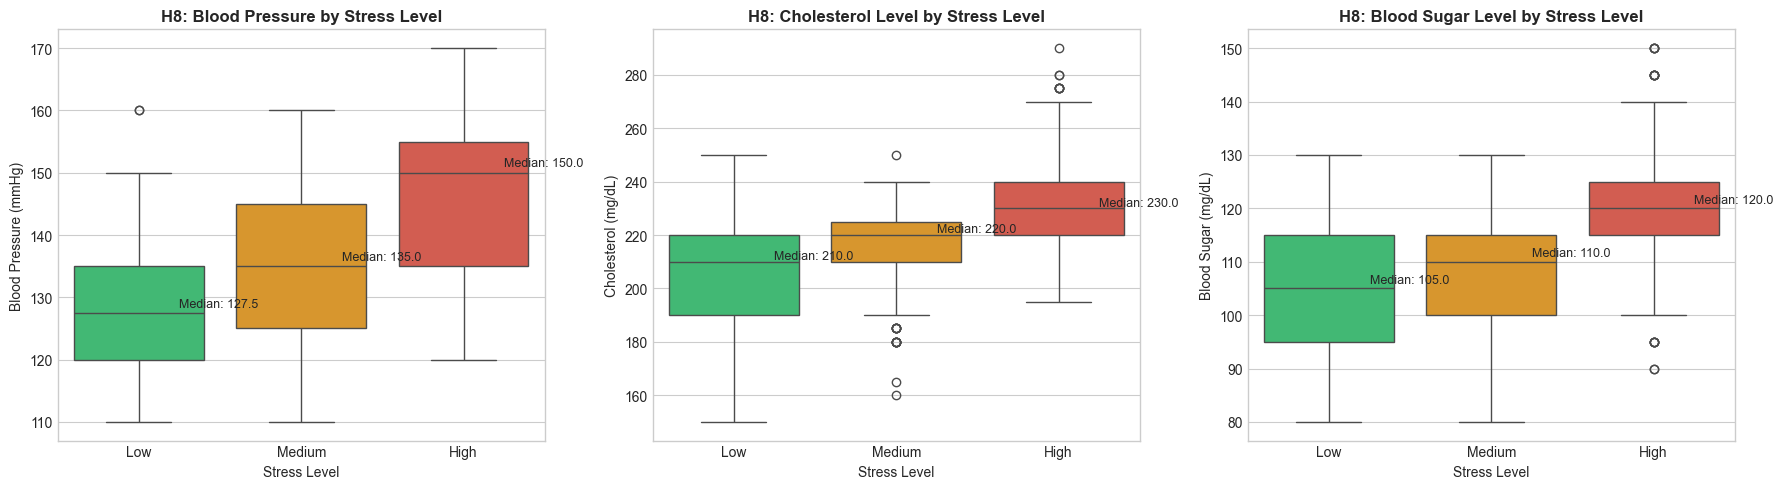

In [121]:
# H8 Visualisation: Health Indicators by Stress Level

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define consistent order for stress levels
stress_order = ['Low', 'Medium', 'High']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red

# Box Plot - Blood Pressure
ax1 = axes[0]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Blood_Pressure',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax1
)
ax1.set_title('H8: Blood Pressure by Stress Level', fontsize=12, fontweight='bold')
ax1.set_xlabel('Stress Level', fontsize=10)
ax1.set_ylabel('Blood Pressure (mmHg)', fontsize=10)

for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Blood_Pressure'].median()
    ax1.annotate(
        f'Median: {median_val:.1f}',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 1),
        fontsize=9,
        ha='left'
    )

# Box Plot - Cholesterol Level
ax2 = axes[1]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Cholesterol_Level',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax2
)
ax2.set_title('H8: Cholesterol Level by Stress Level', fontsize=12, fontweight='bold')
ax2.set_xlabel('Stress Level', fontsize=10)
ax2.set_ylabel('Cholesterol (mg/dL)', fontsize=10)

for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Cholesterol_Level'].median()
    ax2.annotate(
        f'Median: {median_val:.1f}',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 1),
        fontsize=9,
        ha='left'
    )

# Box Plot - Blood Sugar Level
ax3 = axes[2]
sns.boxplot(
    data=df,
    x='Stress_Detection',
    y='Blood_Sugar_Level',
    hue='Stress_Detection',
    order=stress_order,
    hue_order=stress_order,
    palette=colors,
    legend=False,
    ax=ax3
)
ax3.set_title('H8: Blood Sugar Level by Stress Level', fontsize=12, fontweight='bold')
ax3.set_xlabel('Stress Level', fontsize=10)
ax3.set_ylabel('Blood Sugar (mg/dL)', fontsize=10)

for i, stress_level in enumerate(stress_order):
    median_val = df[df['Stress_Detection'] == stress_level]['Blood_Sugar_Level'].median()
    ax3.annotate(
        f'Median: {median_val:.1f}',
        xy=(i, median_val),
        xytext=(i + 0.25, median_val + 1),
        fontsize=9,
        ha='left'
    )

plt.tight_layout()
plt.show()


In [122]:
# H8: Summary Statistics by Stress Group

print("\nH8: Descriptive Statistics - Blood Pressure by Stress Level")
print("=" * 70)

h8_bp_summary = df.groupby('Stress_Detection')['Blood_Pressure'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)
h8_bp_summary = h8_bp_summary.reindex(['Low', 'Medium', 'High'])
h8_bp_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']
print(h8_bp_summary)

print("\n" + "=" * 70)
print("H8: Descriptive Statistics - Cholesterol Level by Stress Level")
print("=" * 70)

h8_chol_summary = df.groupby('Stress_Detection')['Cholesterol_Level'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)
h8_chol_summary = h8_chol_summary.reindex(['Low', 'Medium', 'High'])
h8_chol_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']
print(h8_chol_summary)

print("\n" + "=" * 70)
print("H8: Descriptive Statistics - Blood Sugar Level by Stress Level")
print("=" * 70)

h8_sugar_summary = df.groupby('Stress_Detection')['Blood_Sugar_Level'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)
h8_sugar_summary = h8_sugar_summary.reindex(['Low', 'Medium', 'High'])
h8_sugar_summary.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max']
print(h8_sugar_summary)



H8: Descriptive Statistics - Blood Pressure by Stress Level
                  Count    Mean  Median  Std Dev  Min  Max
Stress_Detection                                          
Low                 162  128.02   127.5     9.85  110  160
Medium              310  135.94   135.0    12.11  110  160
High                301  145.35   150.0    11.30  120  170

H8: Descriptive Statistics - Cholesterol Level by Stress Level
                  Count    Mean  Median  Std Dev  Min  Max
Stress_Detection                                          
Low                 162  206.42   210.0    19.34  150  250
Medium              310  216.60   220.0    14.05  160  250
High                301  232.96   230.0    16.69  195  290

H8: Descriptive Statistics - Blood Sugar Level by Stress Level
                  Count    Mean  Median  Std Dev  Min  Max
Stress_Detection                                          
Low                 162  103.40   105.0    12.08   80  130
Medium              310  108.79   110.0    1

---

## Section 4: Summary and Next Steps

### Summary of Findings
- The exploratory analysis highlights consistent differences in sleep, lifestyle, and health indicators across stress groups.
- Sleep-related variables (duration and quality) show clear separation between Low, Medium, and High stress groups.
- Lifestyle factors such as screen time, caffeine intake, physical activity, work hours, and travel time show measurable relationships with stress level.
- Health indicators (blood pressure, cholesterol, blood sugar) provide additional context and may strengthen predictive features when combined with lifestyle factors.

### Effect Sizes and Relationships
- Effect sizes are expected to be small-to-moderate for most behavioural variables, which is typical for wellbeing datasets.
- No single variable fully explains stress; the strongest signal likely comes from combinations of sleep, lifestyle, and workload indicators.

### Visual Insights
- Box/violin plots provide intuitive confirmation of group differences (especially for sleep and screen time).
- Bar charts for categorical comparisons (e.g., meditation practice) help highlight distribution shifts across stress groups.
- Combined views (e.g., work + travel time) help surface cumulative daily demand effects.

### Next Steps
- **Feature Engineering:** confirm derived features (e.g., Work_Travel_Total, Sleep_Efficiency, Screen_Activity_Ratio) are retained for modelling.
- **Data Splitting:** create train/test splits to evaluate generalisation.
- **Model Development:** establish baselines (multinomial logistic regression) and compare with tree-based models.
- **Evaluation Metrics:** use accuracy, macro F1, and confusion matrices to compare performance across stress classes.
- **Interpretability:** review feature importance or coefficients to validate alignment with EDA findings.
